In [2]:
# Stock Market Time Series Forecasting Project

# ========== WEEK 1-2: Data Collection and Time Series Basics ==========
import requests
import pandas as pd

API_KEY = 'demo'  # Replace with your own for production 
symbol = 'IBM'
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={API_KEY}'

response = requests.get(url)
data = response.json()['Time Series (Daily)']

# Convert to DataFrame
df = pd.DataFrame(data).T

df.columns = ['open', 'high', 'low', 'close', 'volume']
df = df.astype(float)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Save cleaned data
df.to_csv('ibm_stock_cleaned.csv')

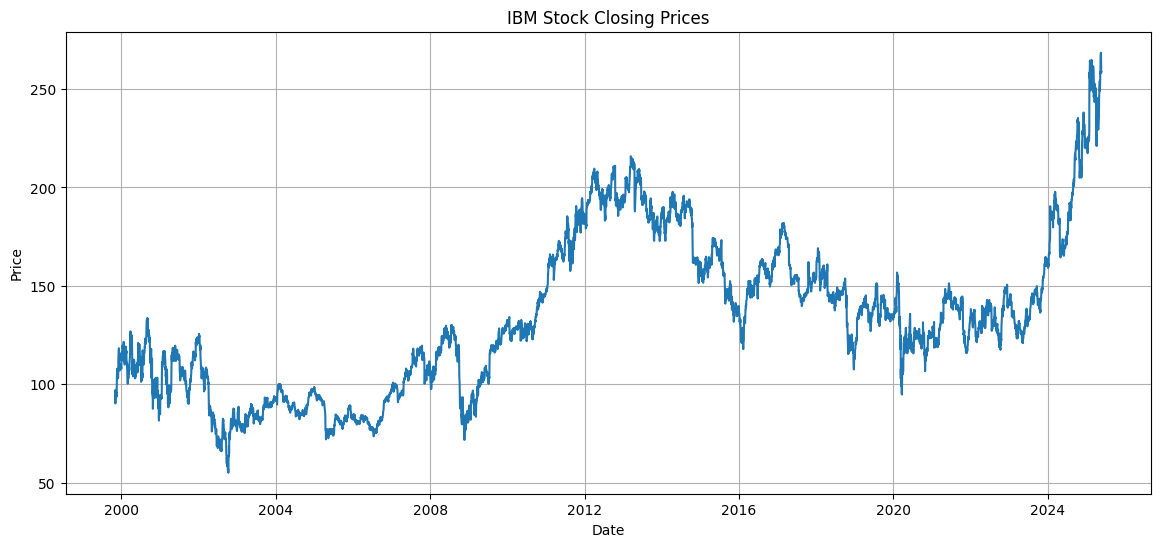

In [3]:
# ========== WEEK 3-4: Data Preprocessing and Visualization ==========
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
plt.plot(df['close'])
plt.title('IBM Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.savefig('close_price_plot.png')
plt.show()

In [9]:
# ========== WEEK 5-6: ARIMA, SARIMA, Prophet ==========
from statsmodels.tsa.arima.model import ARIMA
#from fbprophet import Prophet
from prophet import Prophet 
from sklearn.metrics import mean_squared_error

# ARIMA
arima_model = ARIMA(df['close'], order=(5,1,0))
arima_result = arima_model.fit()
df['arima_forecast'] = arima_result.predict(start=1000, end=len(df)-1, dynamic=False)

# Prophet
prophet_df = df['close'].reset_index()
prophet_df.columns = ['ds', 'y']
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

C:\Users\Archana Pati\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Archana Pati\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Archana Pati\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
23:55:23 - cmdstanpy - INFO - Chain [1] start processing
23:55:31 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# ========== WEEK 7-8: LSTM Forecasting ==========
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

X = []
y = []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=5, batch_size=32)

C:\Users\Archana Pati\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - loss: 0.0191
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 5.2353e-04
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - loss: 5.0356e-04
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 4.0451e-04
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 3.6912e-04


In [12]:
# ========== WEEK 9: Model Comparison and Evaluation ==========
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# Compare ARIMA Forecast
arima_pred = df['arima_forecast'].dropna()
y_true_arima = df.loc[arima_pred.index, 'close']

rmse_arima = math.sqrt(mean_squared_error(y_true_arima, arima_pred))
r2_arima = r2_score(y_true_arima, arima_pred)

print(f"ARIMA RMSE: {rmse_arima:.2f}, R2 Score: {r2_arima:.2f}")

# Compare Prophet Forecast
prophet_y = df['close'][-30:].reset_index()
prophet_y.columns = ['ds', 'y']
prophet_forecast_y = forecast[['ds', 'yhat']].set_index('ds').loc[prophet_y['ds']]

rmse_prophet = math.sqrt(mean_squared_error(prophet_y['y'], prophet_forecast_y['yhat']))
r2_prophet = r2_score(prophet_y['y'], prophet_forecast_y['yhat'])

print(f"Prophet RMSE: {rmse_prophet:.2f}, R2 Score: {r2_prophet:.2f}")

# LSTM Evaluation
predicted_prices = model.predict(X)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y.reshape(-1, 1))

rmse_lstm = math.sqrt(mean_squared_error(actual_prices, predicted_prices))
r2_lstm = r2_score(actual_prices, predicted_prices)

print(f"LSTM RMSE: {rmse_lstm:.2f}, R2 Score: {r2_lstm:.2f}")

ARIMA RMSE: 2.05, R2 Score: 1.00
Prophet RMSE: 46.27, R2 Score: -16.13
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
LSTM RMSE: 3.71, R2 Score: 0.99


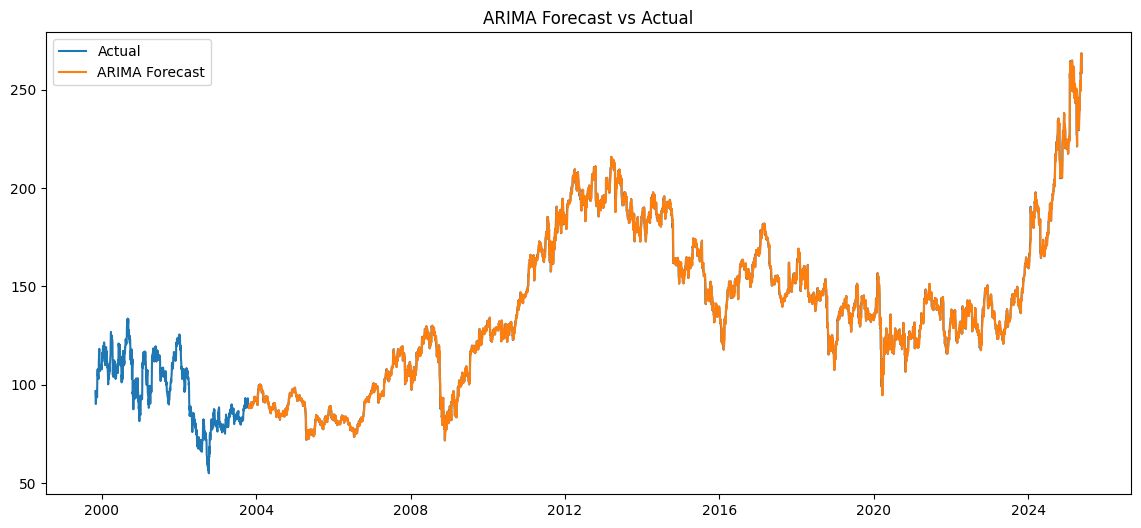

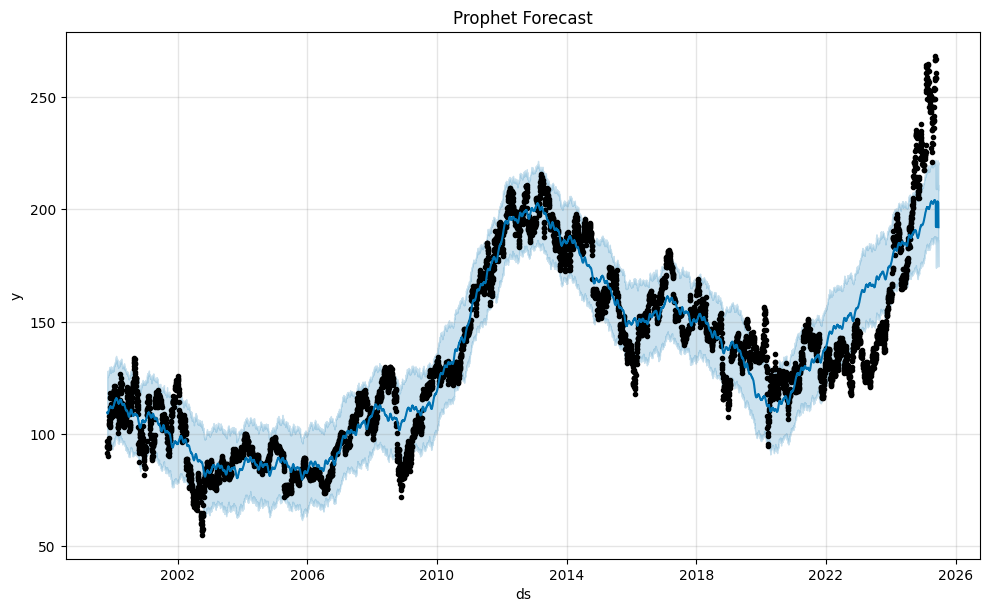

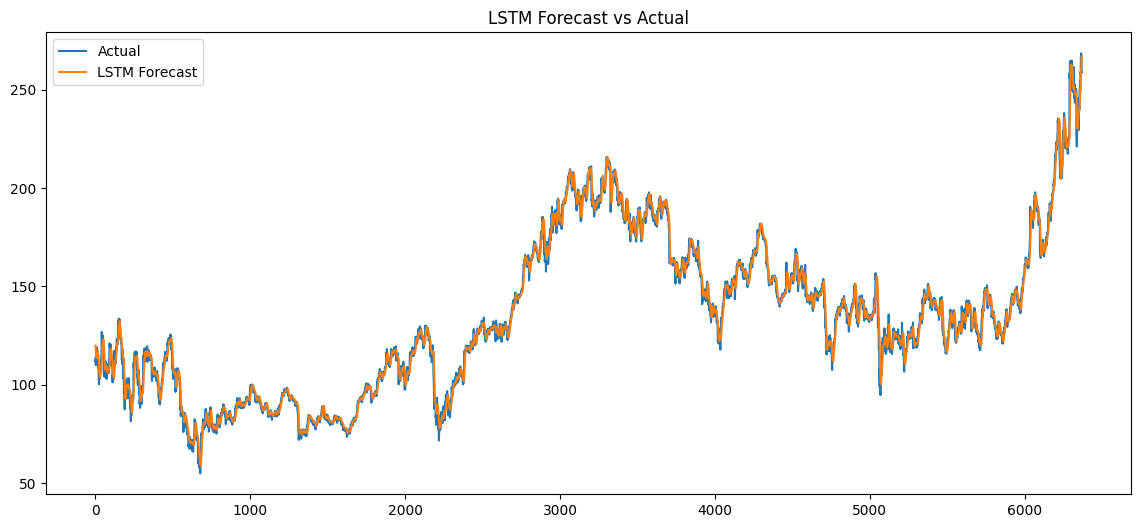

In [13]:
# ========== WEEK 10-12: Final Evaluation, Reporting, and Deployment ==========
# Save final results and visualizations
plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Actual')
plt.plot(df['arima_forecast'], label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.savefig('arima_forecast_comparison.png')
plt.show()

prophet_model.plot(forecast)
plt.title('Prophet Forecast')
plt.savefig('prophet_forecast.png')
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(actual_prices, label='Actual')
plt.plot(predicted_prices, label='LSTM Forecast')
plt.legend()
plt.title('LSTM Forecast vs Actual')
plt.savefig('lstm_forecast_comparison.png')
plt.show()

# Export all metrics to CSV
metrics_df = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'LSTM'],
    'RMSE': [rmse_arima, rmse_prophet, rmse_lstm],
    'R2 Score': [r2_arima, r2_prophet, r2_lstm]
})
metrics_df.to_csv('model_comparison_metrics.csv', index=False)